# Agent-Based Simulation Model of COVID-19 in Python


## Part 1: The based model setup

In [1]:
import numpy as np
import random
import math
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
from collections import Counter
random.seed(24121014)

import warnings
warnings.filterwarnings('ignore')

We first set the state of the agent, which should have 7 states under the simulation of covid-19

- Unexposed: The individual has not been infected yet.
- Asymptomatic and contagious: The individual is infected but does not show symptoms. However, they can still transmit the virus.
- Symptomatic and contagious: The individual is infected, showing symptoms, and is contagious.
- Symptomatic and not contagious: Symptoms are present, but the individual is no longer contagious.
- Post-COVID immune: The individual has recovered and is now immune to the virus.
- Naturally immune: Individuals who are immune to the virus without prior infection.
- Death: The individual has died due to COVID.

In [2]:
# Each of which represents a different health status of the individual
STATES = 7
STATENAMES = [
    "Unexposed",
    "Asymptomatic and contagious",
    "Symptomatic and contagious",
    "Asymptomatic and not contagious",
    "Post-COVID immune",
    "Naturally immune",
    "Death"
]

In real-world COVID-19 models, age plays a significant role in determining mortality rates. Older individuals are more susceptible to severe outcomes, including death, while younger individuals typically have lower mortality rates. We use population distribution data to define the proportion of agents in each age group and assign mortality rates based on age.

We divided our age distribution into 9 groups (Ritchie & Roser, 2024) according to the age distribution in real-world data, and assigned them different mortality rates (CDC, n.d.). The mortality rate is more hypothetical and limited to reality. We limit the mortality rate above 65 years old to 60%, because the mortality rate cannot be greater than 100%.



In [3]:
# Define age groups and the proportion of agents in each group
age_groups = {
    'Under-5': 0.05,   # 5% of the population
    '5-14': 0.1,       # 10% of the population
    '15-29': 0.2,      # 20% of the population
    '30-39': 0.15,     # 15% of the population
    '40-49': 0.15,     # 15% of the population
    '50-64': 0.2,      # 20% of the population
    '65-74': 0.05,     # 5% of the population
    '75-84': 0.05,     # 5% of the population
    '85+': 0.05        # 5% of the population
}

# Define mortality rates capped at 1
mortality_rates = {
    'Under-5': 0.003,    # 0.3% chance of death
    '5-14': 0.001,       # 0.1% chance of death
    '15-29': 0.01,       # 1% chance of death
    '30-39': 0.035,      # 3.5% chance of death
    '40-49': 0.1,        # 10% chance of death
    '50-64': 0.25,       # 25% chance of death
    '65-74': 0.6,        # 60% chance of death
    '75-84': 0.6,        # 60% chance of death
    '85+': 0.6           # 60% chance of death
}


Each agent is created with an initial health state (biostate) and assigned to an age group. Agents will also have additional attributes, such as a countdown timer (biostatecountdown) that tracks the duration they remain in a given state before transitioning to the next state.



In [4]:
def makeAgent(biostate):
    # Assign age group based on defined age distribution
    age_group = random.choices(list(age_groups.keys()), weights=age_groups.values(), k=1)[0]
    return {
        'biostate': biostate,
        'nextbiostate': None,
        'biostatecountdown': None,
        'age_group': age_group  # Assign age group to agent
    }

BioTransition is a matrix of STATES x STATES size that stores the transition probabilities between states, where the sum of the probability of the state moving from the previous stage to the next stage should be equal to 1. We define transition matrices (bioTransitionRate, bioMin, and bioMax) to model the probability and time of transitions between health states. This provides randomness for simulating the duration of different stages of infection and the likelihood of moving from one state to another.

- The duration of the Asymptomatic & contagious is as short as 6 days and long as 10 days

- The duration of the Symptomatic & contagious is as short as 3 days and long as 6 days

- The duration of the Symptomatic & contagious is as short as 2 days and long as 6 days

(Byrne et al., 2020)

Since the post-infection symptoms of the novel coronavirus are relatively complex and there is no more detailed literature that can be fully referenced, the setting here is more of an assumption, although there is literature reference. COVID-19 has a long incubation period and can be transmitted through the respiratory tract.


In [5]:
# Initialize matrices

# The value in the bioTransitionRate represents the probability of moving from the current state to the next
bioTransitionRate = np.zeros((STATES, STATES))
# Minimum and maximum durations for each health state
bioMin = np.ones(STATES)
bioMax = np.ones(STATES)


# Define state durations and transitions

# Asymptomatic & contagious
# The duration of the Asymptomatic & contagious is as short as 4 days and long as 10 days
bioMin[1] = 6
bioMax[1] = 10
bioTransitionRate[1, 2] = 0.5  # Rate of transition to symptomatic & contagious
bioTransitionRate[1, 4] = 1 - bioTransitionRate[1, 2]  # Rate of transition to post-COVID immune

# Symptomatic & contagious
bioMin[2] = 3
bioMax[2] = 6
# If increasing the mortality rate then modifying bioTransitionRate[2, 6]
bioTransitionRate[2, 6] = 0.05  # Transition to death
bioTransitionRate[2, 3] = 1 - bioTransitionRate[2, 6]  # Transition to symptomatic & not contagious

# Asymptomatic & not contagious
bioMin[3] = 2
bioMax[3] = 6
bioTransitionRate[3, 4] = 1.0  # Transition to post-COVID immune
print(bioTransitionRate, bioMin, bioMax)

[[0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.5  0.   0.5  0.   0.  ]
 [0.   0.   0.   0.95 0.   0.   0.05]
 [0.   0.   0.   0.   1.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.  ]] [1. 6. 3. 2. 1. 1. 1.] [ 1. 10.  6.  6.  1.  1.  1.]


### Testing the Agent State Transitions and Simulating the Spread of COVID-19


In [6]:
# Create an agent and infect them
agent = makeAgent(biostate=2)
agent['biostate'] = 1  # Infected but asymptomatic
agent['nextbiostate'] = 2  # Will become symptomatic and contagious
agent['biostatecountdown'] = math.ceil(abs(random.gauss(8, 1))) # Randomly generated by a normal distribution
print(agent)

{'biostate': 1, 'nextbiostate': 2, 'biostatecountdown': 8, 'age_group': '65-74'}


Next, we define two critical functions:

setAgentState: Updates the current state and determines the agent’s next state based on the transition probabilities.

updateAgent: Decreases the countdown and triggers a state transition when the countdown reaches zero. It also introduces a small chance for immunity loss in the post-COVID immune state. Because in the COVID-19 pandemic, some people will be infected with COVID-19 two or three times.

In [ ]:
def setAgentState(agent, biostate):
    agent['biostate'] = biostate
    if bioTransitionRate[biostate - 1, :].sum() > 0:
        agent['biostatecountdown'] = random.choice(
            range(int(bioMin[biostate - 1]), int(bioMax[biostate - 1] + 1))
        )

        # Dynamically adjust the mortality of the current agent without modifying the global matrix
        if biostate == 2:  # Symptomatic and contagious
            mortality_rate = mortality_rates[agent['age_group']]
            local_transition_rate = bioTransitionRate[biostate - 1].copy()
            local_transition_rate[6] = mortality_rate  # The death probability of the current agent
            local_transition_rate[3] = 1 - mortality_rate  # The probability of becoming symptomatic but not contagious

            next_states = list(range(1, STATES + 1))
            agent['nextbiostate'] = random.choices(
                next_states, weights=local_transition_rate, k=1
            )[0]
        else:
            next_states = list(range(1, STATES + 1))
            probabilities = bioTransitionRate[biostate - 1, :]
            agent['nextbiostate'] = random.choices(
                next_states, weights=probabilities, k=1
            )[0]
    else:
        agent['biostatecountdown'] = None
        agent['nextbiostate'] = None
    return agent


def updateAgent(agent):
    if agent['biostatecountdown'] is not None:
        agent['biostatecountdown'] -= 1
        if agent['biostatecountdown'] <= 0:
            # Check if the agent is in the Post-COVID immune state (state 5)
            if agent['biostate'] == 5:  # Post-COVID immune state
                # Introduce a small probability for immunity loss
                immunity_loss_prob = 0.01
                if random.random() < immunity_loss_prob:
                    agent['nextbiostate'] = 1  # Revert to unexposed or reinfected (state 1)
            else:
                # Now set the next state as usual
                agent = setAgentState(agent, agent['nextbiostate'])
    return agent

#### Simulating Agent State Transitions

We simulate the countdown for an agent and observe how they progress through different health states. This function will print the agent's state at each time step.

In [8]:
# Simulate the countdown
continue_simulation = True
while continue_simulation:
    print(f"{agent['biostate']} {agent['biostatecountdown']}")
    agent = updateAgent(agent)
    continue_simulation = agent['biostatecountdown'] is not None

1 8
1 7
1 6
1 5
1 4
1 3
1 2
1 1
2 7
2 6
2 5
2 4
2 3
2 2
2 1
3 4
3 3
3 2
3 1
4 2
4 1


The agent moves from unexposed (state 1) to asymptomatic and contagious (state 2), and then eventually recovers (state 5) or dies (state 7).

#### Testing the Full Agent Lifecycle

We build a function to fully test the lifecycle of an agent. This test function will run until the agent reaches a terminal state (either post-COVID immunity or death) and print the transitions.

In [9]:
def test_AgentState(agent):
    continue_simulation = True
    time = 1

    while continue_simulation:
        # Prints the current time, the agent's biological status number, status name, and status countdown
        print(f"{time} {agent['biostate']} {STATENAMES[agent['biostate'] - 1]} {agent['biostatecountdown']}")
        # Update agent status
        agent = updateAgent(agent)
        # Check whether the simulation continues
        continue_simulation = agent['nextbiostate'] is not None
        time += 1

    print(f"{agent['biostate']} {STATENAMES[agent['biostate'] - 1]} {agent['biostatecountdown']}")

If we start an agent with an unexposed state (stage = 1), nothing happens. Because the pathogen does not develop naturally, but through infection

In [10]:
agent = makeAgent(biostate=1)
# Infect the agent, set biological status to 2 (asymptomatic and infectious)
agent = setAgentState(agent, 1)
test_AgentState(agent)

1 1 Unexposed None
1 Unexposed None


If we add asymptomatic and infectious symptoms to the agent, we can look at its workflow.

In [11]:
# Infect the agent, set biological status to 2 (asymptomatic and infectious)
test_AgentState(setAgentState(makeAgent(biostate=1), 2))

1 2 Asymptomatic and contagious 10
2 2 Asymptomatic and contagious 9
3 2 Asymptomatic and contagious 8
4 2 Asymptomatic and contagious 7
5 2 Asymptomatic and contagious 6
6 2 Asymptomatic and contagious 5
7 2 Asymptomatic and contagious 4
8 2 Asymptomatic and contagious 3
9 2 Asymptomatic and contagious 2
10 2 Asymptomatic and contagious 1
11 4 Asymptomatic and not contagious 2
12 4 Asymptomatic and not contagious 1
5 Post-COVID immune None


We can see the process of agent from illness to recovery, and every time we run this test case, the return result may be different.
After we have a random infection process, we can simulate the transmission Function of COVID-19

In [12]:
def simulate_spread(numAgents, naturalImmunity, numInteractions, numDays, contagion_prob):
    # Initialize the agent pool
    pool = []
    for _ in range(numAgents):
        biostate = random.choices([1, 6], weights=[1 - naturalImmunity, naturalImmunity], k=1)[0]
        agent = makeAgent(biostate=biostate)
        pool.append(agent)

    # Infect the initial 3 agents
    numInfected = 3
    infected_indices = random.sample(range(numAgents), numInfected)
    for i in infected_indices:
        pool[i] = setAgentState(pool[i], 2)

    # Initialize state history records
    disthistory = []

    # Start the simulation
    for day in range(1, numDays + 1):
        sneezeOn = []
        for agent_id in range(numAgents):
            for _ in range(numInteractions):
                partner_id = random.randrange(numAgents)
                sneezeOn.append((agent_id, partner_id))

        for agent1_id, agent2_id in sneezeOn:
            agent1 = pool[agent1_id]
            agent2 = pool[agent2_id]

            if (agent1['biostate'] in [2, 3]) and (agent2['biostate'] == 1) and (random.random() < contagion_prob):
                pool[agent2_id] = setAgentState(agent2, 2)

        # Update each agent's state
        for i in range(numAgents):
            pool[i] = updateAgent(pool[i])

        # Track the distribution of biostates
        biostates = [agent['biostate'] for agent in pool]
        distrib = Counter(biostates)
        day_distrib = [distrib.get(state, 0) for state in range(1, 8)]
        disthistory.append(day_distrib)

    # Convert the history into a DataFrame
    disthistory_df = pd.DataFrame(disthistory, columns=STATENAMES)
    disthistory_df['day'] = range(1, numDays + 1)

    # Return the DataFrame
    return disthistory_df

After setting all functions, we set a total of 1,000 agents, of which 1 percent have innate immunity to COVID-19, and agents will interact with other agents an average of 10 times a day, and we assume the contagion rate is 0.05

In [13]:

numAgents = 1000               # Total agency
naturalImmunity = 0.01         # 1% of surrogates are inherently immune
numInteractions = 10           # Average number of interactions per agent per day
numDays = 50                   # The total number of days simulated
contagion_prob = 0.05            # Infection probability

disthistory_df = simulate_spread(numAgents, naturalImmunity, numInteractions, numDays, contagion_prob)
show = disthistory_df.iloc[::5, :]
print(show.to_string(index=False))

 Unexposed  Asymptomatic and contagious  Symptomatic and contagious  Asymptomatic and not contagious  Post-COVID immune  Naturally immune  Death  day
       981                            6                           0                                0                  0                13      0    1
       922                           63                           0                                2                  0                13      0    6
       578                          382                           8                                9                  8                13      2   11
       123                          626                          46                               95                 66                13     31   16
        31                          261                          91                              197                339                13     68   21
        14                           45                          41                              145

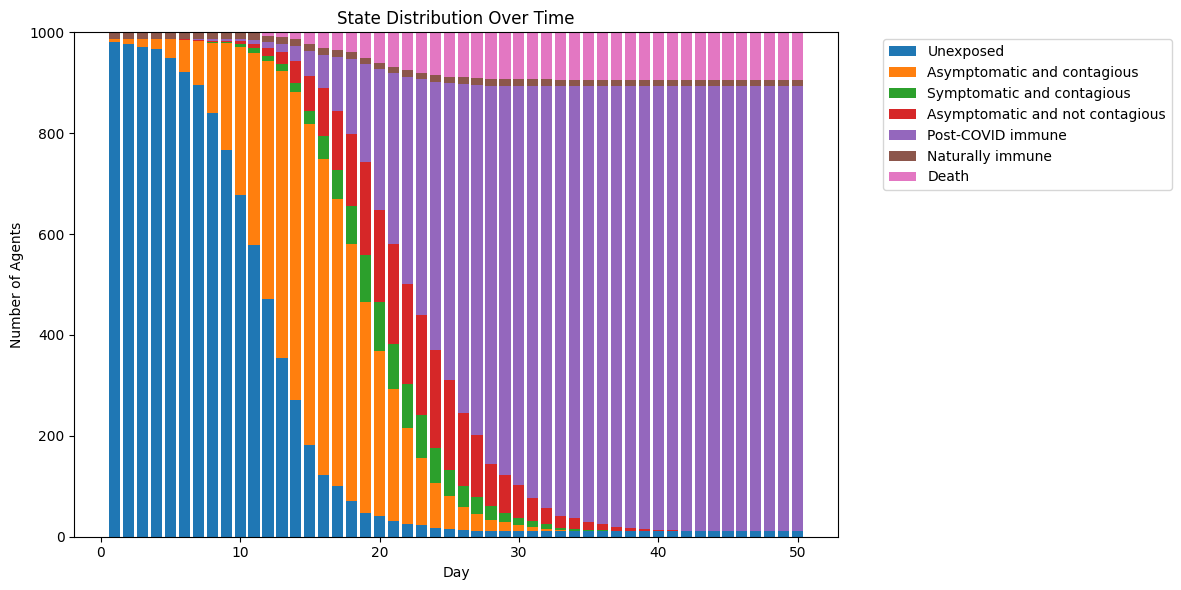

In [14]:
# Draw the final result
histlong = pd.melt(disthistory_df, id_vars=['day'], var_name='State', value_name='Count')

plt.figure(figsize=(12, 6))
bottom_values = np.zeros(numDays)
states = histlong['State'].unique()
for state in states:
    subset = histlong[histlong['State'] == state]
    plt.bar(subset['day'], subset['Count'], label=state, bottom=bottom_values)
    bottom_values += subset['Count'].values

plt.xlabel('Day')
plt.ylabel('Number of Agents')
plt.title('State Distribution Over Time')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

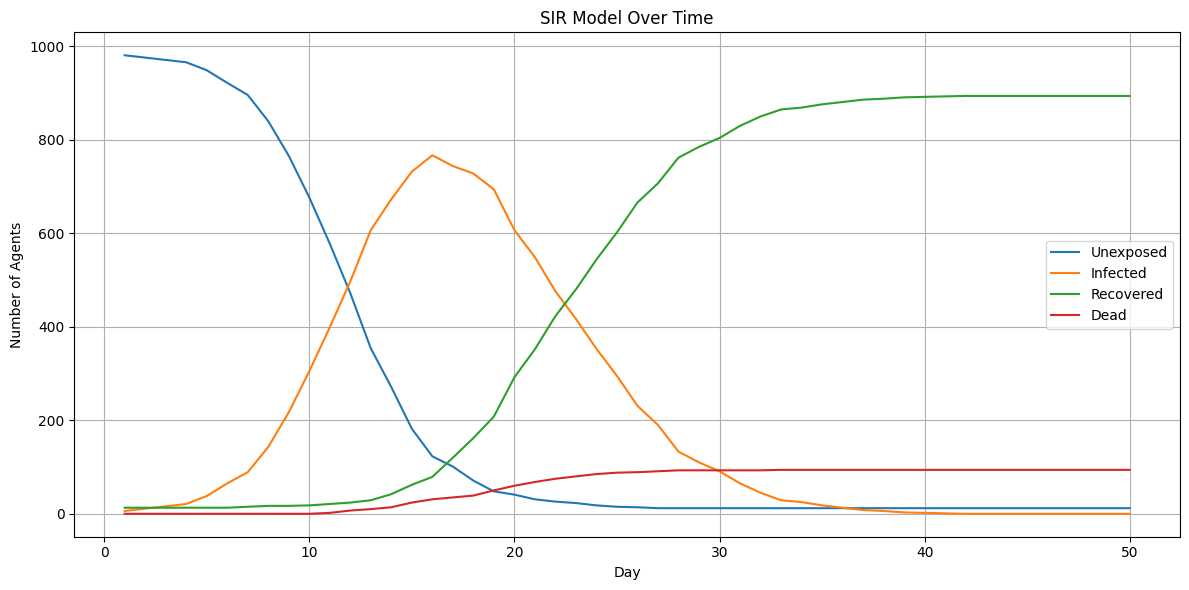

In [15]:
# Graph the SIR Model

sir = pd.DataFrame({
    'day': disthistory_df['day'],
    'Unexposed': disthistory_df['Unexposed'],
    'infected': disthistory_df['Asymptomatic and contagious']
    + disthistory_df['Symptomatic and contagious']+ disthistory_df['Asymptomatic and not contagious'],
    'recovered':  disthistory_df['Post-COVID immune'] + disthistory_df['Naturally immune'],
    'Dead': disthistory_df['Death']
})

sir_long = pd.melt(sir, id_vars=['day'], var_name='State', value_name='Count')

plt.figure(figsize=(12, 6))
for state in ['Unexposed', 'infected', 'recovered', 'Dead']:
    subset = sir_long[sir_long['State'] == state]
    plt.plot(subset['day'], subset['Count'], label=state.capitalize())

plt.xlabel('Day')
plt.ylabel('Number of Agents')
plt.title('SIR Model Over Time')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

We can see a rapid increase in the population in the Post-COVID immune State, with the infected population peaking at more than 600 people around day 17-19, then declining rapidly and reaching zero around day 40

## Part 2: Human behavior application

### Part 2.1 Social Network

In the real world, human interactions are typically constrained by social circles or communities rather than random, completely unstructured encounters. People interact more frequently with those in their social network, which influences how diseases spread. Random interactions, as assumed in many simplified models, do not reflect the structured nature of real-world human behavior.

To address this, we introduce a Barabási–Albert (BA) scale-free network to model a more realistic social structure. In such a network, a few individuals have many connections (hubs), while most have fewer, mimicking how some people have larger social networks and interact with more individuals.

We use a BA model to simulate the social network for the agents. The network is created with a specified number of agents, and each agent is connected to a few others based on the network's degree of connectivity.


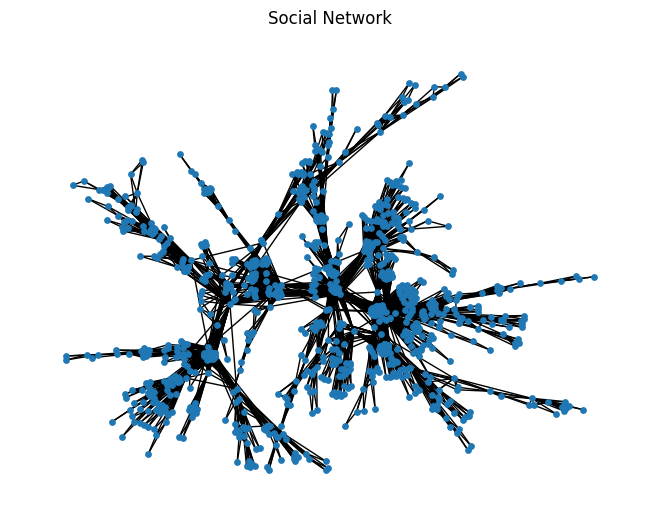

In [16]:

def create_social_network(num_agents, steps, power):

    network = nx.barabasi_albert_graph(num_agents, int(power))

    # Increase connections between adjacent agents (controlled by steps)
    for step in range(2, steps+1):
        new_edges = []
        for node in network.nodes:
            neighbors = list(nx.single_source_shortest_path_length(network, node, cutoff=step))
            for neighbor in neighbors:
                if neighbor != node and not network.has_edge(node, neighbor):
                    new_edges.append((node, neighbor))
        network.add_edges_from(new_edges)

    return network

# Create a 1000-node social network
social_network = create_social_network(numAgents, steps=2, power=1)

nx.draw(social_network, node_size=15)
plt.title("Social Network")
plt.show()

Visualizing this social network helps to validate whether it aligns with expected real-world behaviors, such as some people having more social connections than others.

Now that we have a social network, we integrate it into the infection simulation. Instead of interacting randomly, agents will interact mostly with their neighbors in the network (95% of interactions), and only a small proportion of interactions will be random (5%).

In [17]:
# sample_from_network=0.95 indicates that 95% of interactions occur within the social network and 5% of interactions are random
def simulate_spread_with_network(social_network, agents, num_interactions, num_days, contagion_prob, sample_from_network=0.95):
    # Records the daily status distribution
    disthistory = []

    for day in range(1, num_days + 1):
        sneezeOn = []

        # Generate interactions for each agent
        for agent_id in range(len(agents)):
            for _ in range(num_interactions):
                if random.random() < sample_from_network:
                    # Choose who to interact with from your social network
                    neighbors = list(social_network.neighbors(agent_id))
                    if neighbors:
                        partner_id = random.choice(neighbors)
                    else:
                        # If there are no neighbors, randomly choose who to interact with
                        partner_id = random.randrange(len(agents))
                else:
                    # Choose the interactive objects at random
                    partner_id = random.randrange(len(agents))
                sneezeOn.append((agent_id, partner_id))

        # Simulated virus transmission
        for agent1_id, agent2_id in sneezeOn:
            agent1 = agents[agent1_id]
            agent2 = agents[agent2_id]
            if (agent1['biostate'] in [2, 3]) and (agent2['biostate'] == 1) and (random.random() < contagion_prob):
                agents[agent2_id] = setAgentState(agents[agent2_id], 2)

        # Update the status of each agent
        for i in range(len(agents)):
            agents[i] = updateAgent(agents[i])

        # Record the status distribution for each day
        biostates = [agent['biostate'] for agent in agents]
        distrib = Counter(biostates)
        day_distrib = [distrib.get(state, 0) for state in range(1, 8)]
        disthistory.append(day_distrib)

    disthistory_df = pd.DataFrame(disthistory, columns=STATENAMES)
    disthistory_df['day'] = range(1, num_days + 1)

    return disthistory_df

After we set the function of our social network contagion model, we need to establish initialize_and_infect_agentss to meet the need of resetting agent pool in our subsequent model iterations

In [18]:
# Generating agent pool
def initialize_agents(num_agents, natural_immunity=0.01):
    agents = []
    for i in range(num_agents):
        # Set the initial state based on the given probability, with 1 representing susceptible and 6 representing natural immunity
        biostate = random.choices([1, 6], weights=[1 - natural_immunity, natural_immunity], k=1)[0]
        agent = makeAgent(biostate=biostate)
        agents.append(agent)
    return agents

# Infected the primary agent, only infected 3 people
def infect_initial_agents(agents):
    infected_indices = random.sample(range(len(agents)), 3)
    for i in infected_indices:
        agents[i] = setAgentState(agents[i], 2)  # Set the status to infected
    return agents


Once we incorporate the social network, we simulate the spread of COVID-19 among agents who now interact based on their network connections.



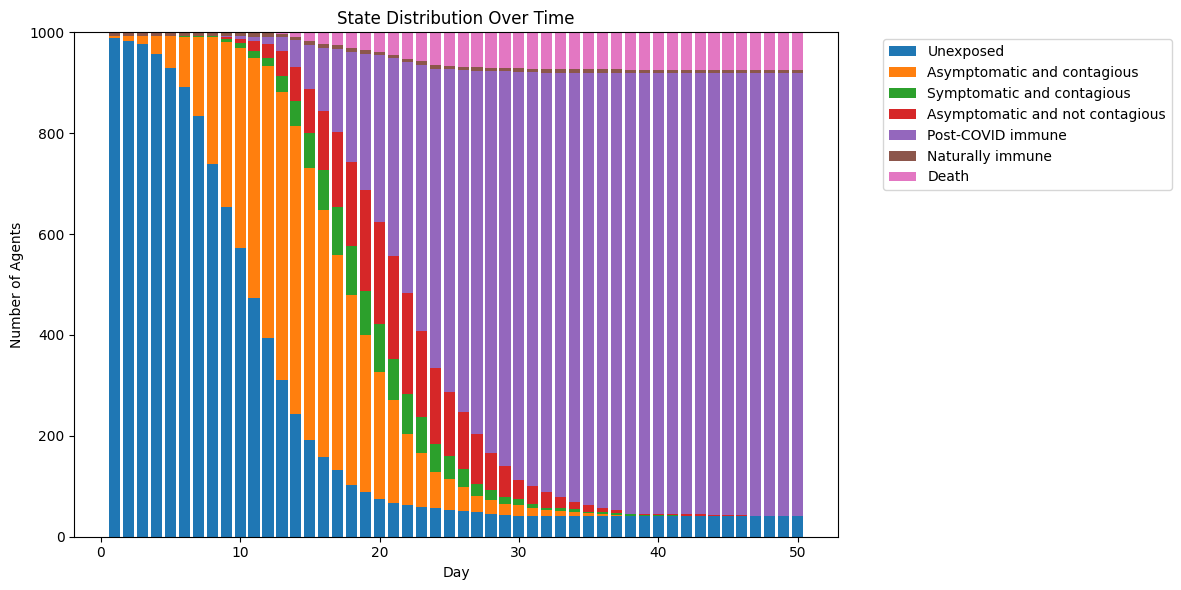

In [19]:

# Initializing agent
agents = initialize_agents(numAgents)
agents = infect_initial_agents(agents)


disthistory_df = simulate_spread_with_network(social_network, agents, num_interactions=10, num_days=50, contagion_prob=0.1)


plt.figure(figsize=(12, 6))
bottom_values = np.zeros(len(disthistory_df))
for state in STATENAMES:
    plt.bar(disthistory_df['day'], disthistory_df[state], label=state, bottom=bottom_values)
    bottom_values += disthistory_df[state]

plt.xlabel('Day')
plt.ylabel('Number of Agents')
plt.title('State Distribution Over Time')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

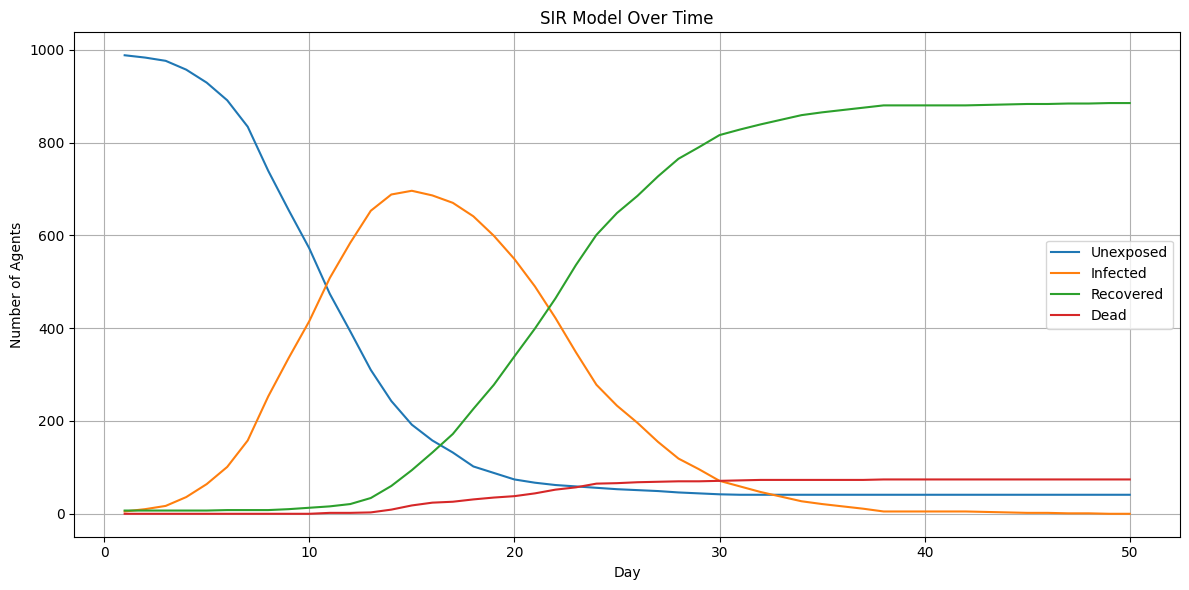

In [20]:

sir = pd.DataFrame({
    'day': disthistory_df['day'],
    'Unexposed': disthistory_df['Unexposed'],
    'infected': disthistory_df['Asymptomatic and contagious'] + disthistory_df['Symptomatic and contagious']+ disthistory_df['Asymptomatic and not contagious'],
    'recovered':  disthistory_df['Post-COVID immune'] + disthistory_df['Naturally immune'],
    'Dead': disthistory_df['Death']
})

sir_long = pd.melt(sir, id_vars=['day'], var_name='State', value_name='Count')

plt.figure(figsize=(12, 6))
for state in ['Unexposed', 'infected', 'recovered', 'Dead']:
    subset = sir_long[sir_long['State'] == state]
    plt.plot(subset['day'], subset['Count'], label=state.capitalize())

plt.xlabel('Day')
plt.ylabel('Number of Agents')
plt.title('SIR Model Over Time')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [21]:
show = disthistory_df.iloc[::5, :]
print(show.to_string(index=False))

 Unexposed  Asymptomatic and contagious  Symptomatic and contagious  Asymptomatic and not contagious  Post-COVID immune  Naturally immune  Death  day
       988                            5                           0                                0                  0                 7      0    1
       891                          100                           1                                0                  1                 7      0    6
       474                          475                          14                               19                  9                 7      2   11
       158                          489                          81                              116                125                 7     24   16
        67                          204                          82                              204                392                 7     44   21
        51                           47                          36                              113

We can find that if the virus is spread randomly based on social networks, the total number of infected people is similar, but the number of deaths is more than random infect



### Part 2.2 Symptoms Affecting Human Behavior

In addition to social network structures, human behavior changes when people show symptoms of illness. Typically, symptomatic individuals reduce their social interactions, either by self-isolation or by government-imposed measures.



In [22]:
def simulate_spread_with_network(social_network, agents, num_interactions, num_days, contagion_prob, sample_from_network=0.95):
    disthistory = []
    for day in range(1, num_days + 1):
        sneezeOn = []

        for agent_id in range(len(agents)):
            agent = agents[agent_id]

            # **Adjust the number of interactions based on the health of the agent**
            if agent['biostate'] in [2, 3]:  # Symptomatic individuals will still travel without symptoms
                # Reduce the number of interactions when symptomatic (e.g., halve)
                adjusted_interactions = max(1, num_interactions // 2)
            else:
                adjusted_interactions = num_interactions

            for _ in range(adjusted_interactions):
                if random.random() < sample_from_network:
                    # Choose who to interact with from your social network
                    neighbors = list(social_network.neighbors(agent_id))
                    if neighbors:
                        partner_id = random.choice(neighbors)
                    else:
                        # If you don't have a neighbor, randomly select the interactive object
                        partner_id = random.randrange(len(agents))
                else:
                    # Choose the interactive objects at random
                    partner_id = random.randrange(len(agents))
                sneezeOn.append((agent_id, partner_id))

        # Simulated virus transmission
        for agent1_id, agent2_id in sneezeOn:
            agent1 = agents[agent1_id]
            agent2 = agents[agent2_id]
            if (agent1['biostate'] in [2, 3]) and (agent2['biostate'] == 1) and (random.random() < contagion_prob):
                            agents[agent2_id] = setAgentState(agents[agent2_id], 2)

        # Update the status of each agent
        for i in range(len(agents)):
            agents[i] = updateAgent(agents[i])

        # Record the status distribution for each day
        biostates = [agent['biostate'] for agent in agents]
        distrib = Counter(biostates)
        day_distrib = [distrib.get(state, 0) for state in range(1, 8)]
        disthistory.append(day_distrib)
    disthistory_df = pd.DataFrame(disthistory, columns=STATENAMES)
    disthistory_df['day'] = range(1, num_days + 1)

    return disthistory_df


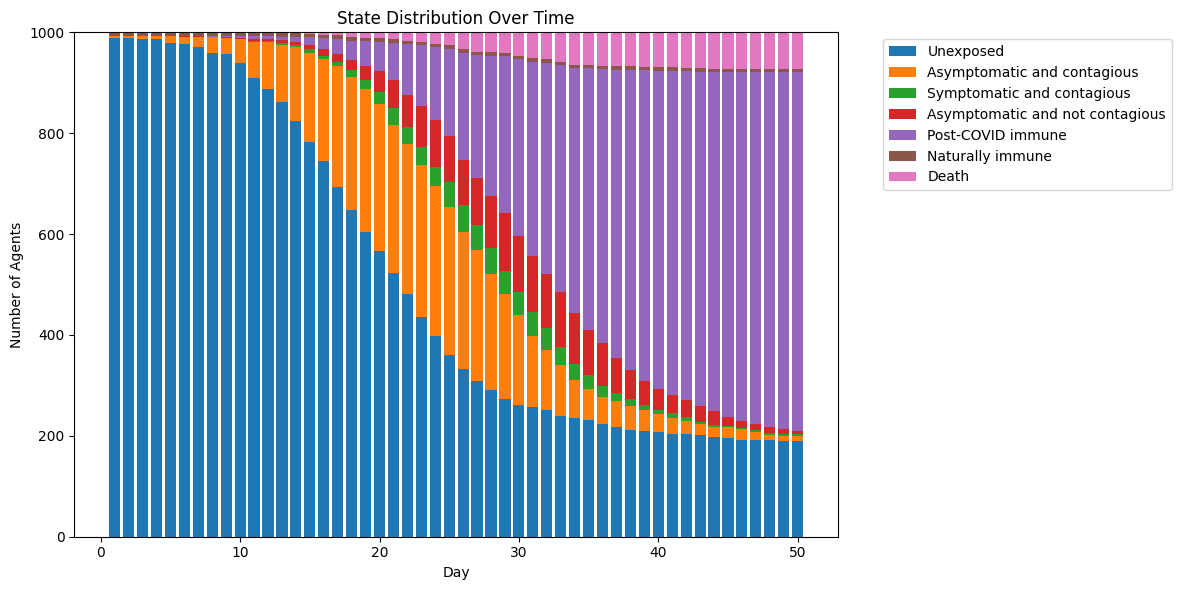

In [23]:

agents = initialize_agents(numAgents)
agents = infect_initial_agents(agents)


disthistory_df = simulate_spread_with_network(social_network, agents, num_interactions=10, num_days=50, contagion_prob=0.1)


plt.figure(figsize=(12, 6))
bottom_values = np.zeros(len(disthistory_df))
for state in STATENAMES:
    plt.bar(disthistory_df['day'], disthistory_df[state], label=state, bottom=bottom_values)
    bottom_values += disthistory_df[state]

plt.xlabel('Day')
plt.ylabel('Number of Agents')
plt.title('State Distribution Over Time')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

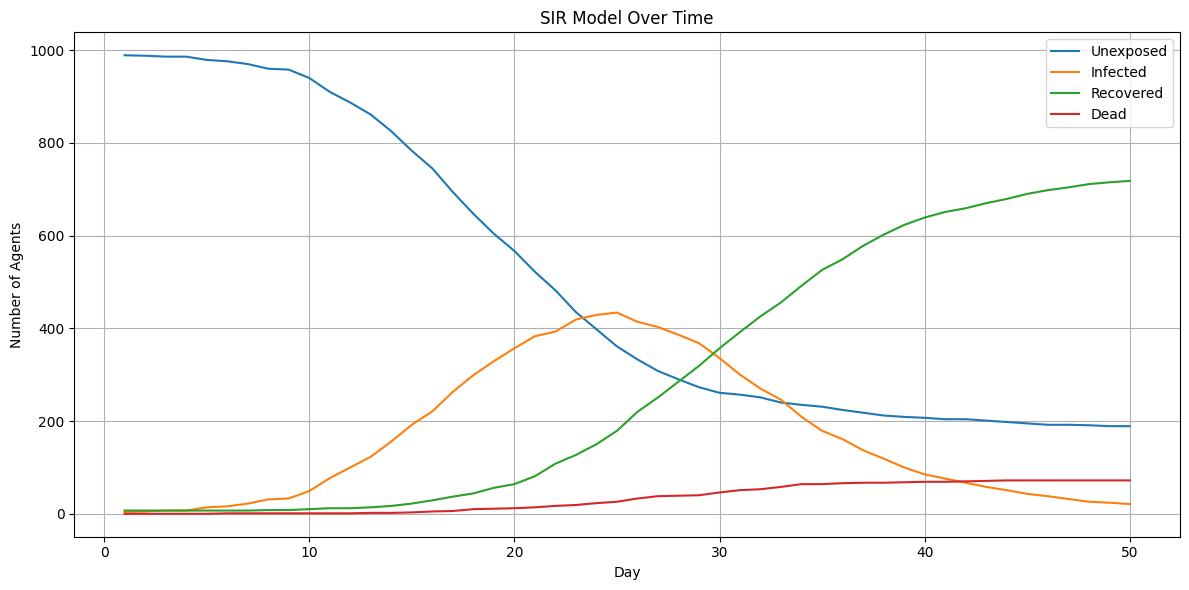

In [24]:

sir = pd.DataFrame({
    'day': disthistory_df['day'],
    'Unexposed': disthistory_df['Unexposed'],
    'infected': disthistory_df['Asymptomatic and contagious'] + disthistory_df['Symptomatic and contagious']+ disthistory_df['Asymptomatic and not contagious'],
    'recovered':  disthistory_df['Post-COVID immune'] + disthistory_df['Naturally immune'],
    'Dead': disthistory_df['Death']
})

sir_long = pd.melt(sir, id_vars=['day'], var_name='State', value_name='Count')

plt.figure(figsize=(12, 6))
for state in ['Unexposed', 'infected', 'recovered', 'Dead']:
    subset = sir_long[sir_long['State'] == state]
    plt.plot(subset['day'], subset['Count'], label=state.capitalize())

plt.xlabel('Day')
plt.ylabel('Number of Agents')
plt.title('SIR Model Over Time')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

The first is that we cut the number of infected people by half. However, the duration of the outbreak is much longer, with the peak moving backwards to a 20-30 day range of about 25 days.
We can find from this part that if everyone is rational and faces the symptoms of the new coronavirus normally, the virus will actually die out quickly and eventually some people will not be infected with the new coronavirus

## Part 3 Covid-19 Attributes Enhancement

### Part 3.1 Super-Infectious Behavior

In reality, not all individuals behave rationally, and home isolation can be challenging to enforce. As a result, some infected individuals may continue interacting with others despite being contagious, leading to higher transmission rates. To model this behavior, we introduce a new element, "Super-Spreaders", who:


- Engage in more frequent interactions with others compared to non-super-spreaders.

- Have a higher likelihood of infecting others during interactions.

- Represent a small proportion of the infected population.

We will add a probability where a certain percentage of infected agents will be designated as "super spreaders"

In [25]:
# Define the probability that an infected agent is a super-spreader
super_spreader_prob = 0.05  # 5% of infected agents are super-spreaders

def makeAgent(biostate):
    age_group = random.choices(list(age_groups.keys()), weights=age_groups.values(), k=1)[0]
    return {
        'biostate': biostate,
        'nextbiostate': None,
        'biostatecountdown': None,
        'age_group': age_group,
        'super_spreader': False
    }

Assign super-spreader status to agents when they enter an infectious state.


In [26]:
def setAgentState(agent, biostate):
    agent['biostate'] = biostate
    
    # Update Super Spreader status
    if biostate in [2, 3]:  # If the agent is now infected
        agent['super_spreader'] = random.random() < super_spreader_prob
    else:
        agent['super_spreader'] = False  # If the status is not infected, set it to False

    # Below is the original state countdown and the next state Settings
    if bioTransitionRate[biostate - 1, :].sum() > 0:
        agent['biostatecountdown'] = random.choice(
            range(int(bioMin[biostate - 1]), int(bioMax[biostate - 1] + 1))
        )
        if biostate == 2:
            mortality_rate = mortality_rates[agent['age_group']]
            local_transition_rate = bioTransitionRate[biostate - 1].copy()
            local_transition_rate[6] = mortality_rate
            local_transition_rate[3] = 1 - mortality_rate

            next_states = list(range(1, STATES + 1))
            agent['nextbiostate'] = random.choices(
                next_states, weights=local_transition_rate, k=1
            )[0]
        else:
            next_states = list(range(1, STATES + 1))
            probabilities = bioTransitionRate[biostate - 1, :]
            agent['nextbiostate'] = random.choices(
                next_states, weights=probabilities, k=1
            )[0]
    else:
        agent['biostatecountdown'] = None
        agent['nextbiostate'] = None
    return agent


 Adjust the interaction frequency and contagion probability for super-spreaders.

In [27]:
def simulate_spread_with_network(social_network, agents, num_interactions, num_days, contagion_prob, sample_from_network=0.95):

    disthistory = []

    for day in range(1, num_days + 1):
        sneezeOn = []
        # Generate interactions for each agent
        for agent_id in range(len(agents)):
            agent = agents[agent_id]


            # **Adjust interaction times**
            if agent['super_spreader']:
                adjusted_interactions = num_interactions * 3  # Super spreaders interact more
            elif agent['biostate'] in [2, 3]:
                adjusted_interactions = max(1, num_interactions // 2)
            else:
                adjusted_interactions = num_interactions
            for _ in range(adjusted_interactions):
                if random.random() < sample_from_network:
                    neighbors = list(social_network.neighbors(agent_id))
                    if neighbors:
                        partner_id = random.choice(neighbors)
                    else:
                        partner_id = random.randrange(len(agents))
                else:
                    partner_id = random.randrange(len(agents))
                sneezeOn.append((agent_id, partner_id))
        for agent1_id, agent2_id in sneezeOn:
            agent1 = agents[agent1_id]
            agent2 = agents[agent2_id]

            # **Let's recalculate the adjusted_contagion_prob here**
            if agent1['super_spreader']:
                adjusted_contagion_prob = contagion_prob * 2
            else:
                adjusted_contagion_prob = contagion_prob


            if (agent1['biostate'] in [2, 3]) and (agent2['biostate'] == 1):
                if random.random() < adjusted_contagion_prob:
                    agents[agent2_id] = setAgentState(agents[agent2_id], 2)
        for i in range(len(agents)):
            agents[i] = updateAgent(agents[i])
        # Record the status distribution for each day
        biostates = [agent['biostate'] for agent in agents]
        distrib = Counter(biostates)
        day_distrib = [distrib.get(state, 0) for state in range(1, 8)]
        disthistory.append(day_distrib)
    disthistory_df = pd.DataFrame(disthistory, columns=STATENAMES)
    disthistory_df['day'] = range(1, num_days + 1)

    return disthistory_df


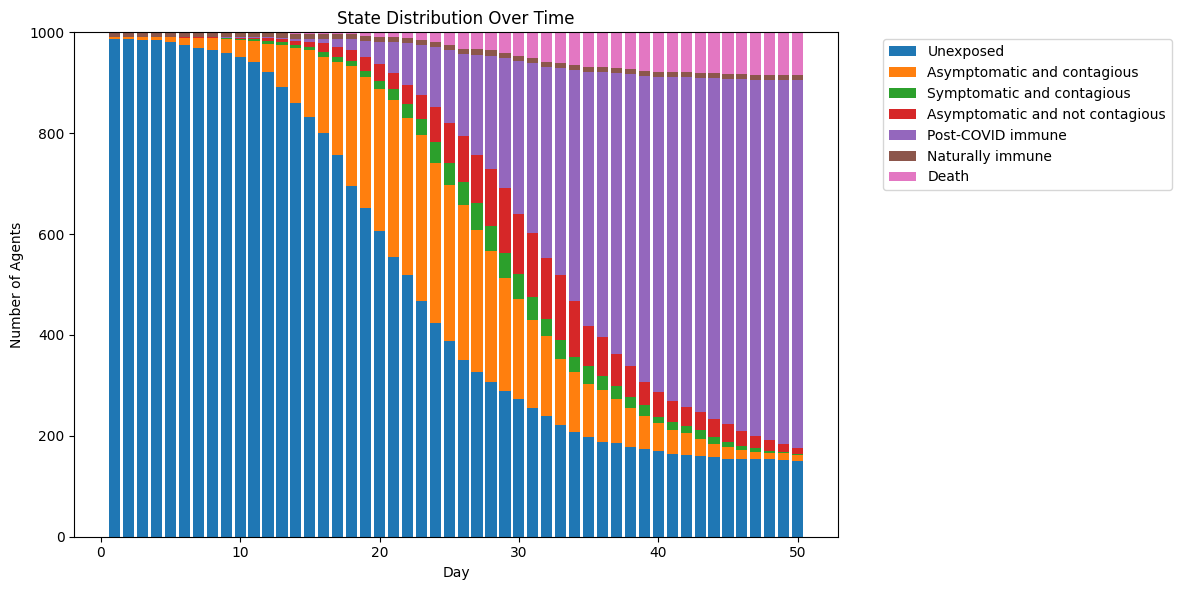

In [28]:
agents = initialize_agents(numAgents)
agents = infect_initial_agents(agents)

disthistory_df = simulate_spread_with_network(social_network, agents, num_interactions=10, num_days=50, contagion_prob=0.1)

plt.figure(figsize=(12, 6))
bottom_values = np.zeros(len(disthistory_df))
for state in STATENAMES:
    plt.bar(disthistory_df['day'], disthistory_df[state], label=state, bottom=bottom_values)
    bottom_values += disthistory_df[state]

plt.xlabel('Day')
plt.ylabel('Number of Agents')
plt.title('State Distribution Over Time')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

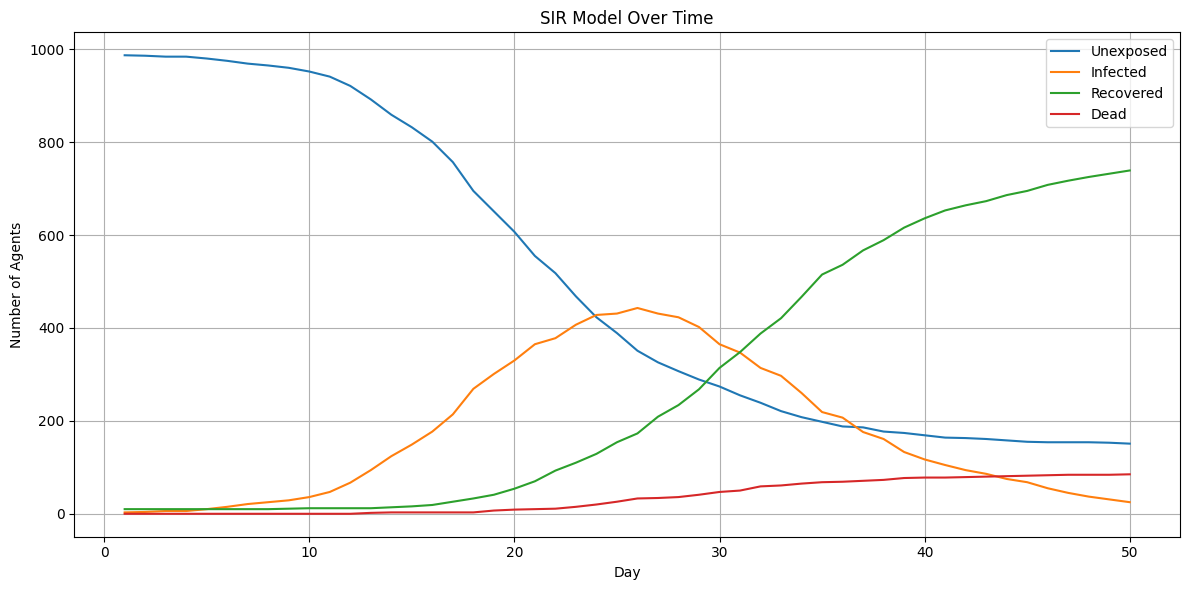

In [29]:

sir = pd.DataFrame({
    'day': disthistory_df['day'],
    'Unexposed': disthistory_df['Unexposed'],
    'infected': disthistory_df['Asymptomatic and contagious'] + disthistory_df['Symptomatic and contagious']+ disthistory_df['Asymptomatic and not contagious'],
    'recovered':  disthistory_df['Post-COVID immune'] + disthistory_df['Naturally immune'],
    'Dead': disthistory_df['Death']
})

sir_long = pd.melt(sir, id_vars=['day'], var_name='State', value_name='Count')

plt.figure(figsize=(12, 6))
for state in ['Unexposed', 'infected', 'recovered', 'Dead']:
    subset = sir_long[sir_long['State'] == state]
    plt.plot(subset['day'], subset['Count'], label=state.capitalize())

plt.xlabel('Day')
plt.ylabel('Number of Agents')
plt.title('SIR Model Over Time')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In the case of enhanced virus and simulated irrational people, the peak number of infected people was higher, but the peak of the total number of infected people did not exceed that in the simulation where only the Network attribute was added, and the peak time moved to around 18-19 days.

While the number of infections has risen rapidly, the outbreak has also subsided relatively quickly. The point at which the number of infections fell to near zero was around Day 30, indicating that the virus spread quickly and ended quickly.

The addition of super-spreaders accelerated the spread of the epidemic, resulting in a rapid peak in the number of infected people in a short period of time, and a rapid rise in the number of recovered people.

### Part 3.2 Introducing Covid-19 Variants

In this section, we incorporate Covid-19 variants into our simulation model. Variants can have higher transmission rates and potentially increased mortality compared to the original strain. This makes the variant strain a critical factor to account for when simulating virus spread.


- Attributes need to be added to the agent to distinguish whether it is infected with a variant strain.

- When an infected person comes into contact with a susceptible person, if the infected person carries the variant strain, then the susceptible person may be infected with the variant strain.

- In the process of status update, it is necessary to consider the influence of variant strains on state transition and mortality.

In [30]:
# Define the transmission probability and fatality rate of the variant strain
variant_contagion_prob = 0.2  # Suppose the mutant strain has a higher probability of transmission
variant_mortality_multiplier = 1.5
variant_initial_infection_prob = 0.1


# Modify the makeAgent function to add the variant_infected attribute
def makeAgent(biostate):
    age_group = random.choices(list(age_groups.keys()), weights=age_groups.values(), k=1)[0]
    return {
        'biostate': biostate,
        'nextbiostate': None,
        'biostatecountdown': None,
        'age_group': age_group,
        'super_spreader': False,
        'variant_infected': False  # Initialize to an uninfected mutant strain
    }

def setAgentState(agent, biostate):
    agent['biostate'] = biostate

    if biostate in [2, 3]:
        agent['super_spreader'] = random.random() < super_spreader_prob

        # If the agent is newly infected, there is a certain probability of infection with the mutant strain
        if agent['variant_infected'] is None:  # If a variant strain has not been identified before
            agent['variant_infected'] = random.random() < variant_initial_infection_prob  # There is a certain probability of initial infection with mutant strains
    else:
        agent['super_spreader'] = False  # If the status is not infected, set it to False
        agent['variant_infected'] = False  # If the status is not infected, set it to False

    if bioTransitionRate[biostate - 1, :].sum() > 0:
        agent['biostatecountdown'] = random.choice(
            range(int(bioMin[biostate - 1]), int(bioMax[biostate - 1] + 1))
        )

        if biostate == 2:
            mortality_rate = mortality_rates[agent['age_group']]

            # If infected with a variant strain, adjust the mortality rate
            if agent['variant_infected']:
                mortality_rate *= variant_mortality_multiplier

            local_transition_rate = bioTransitionRate[biostate - 1].copy()
            local_transition_rate[6] = mortality_rate
            local_transition_rate[3] = 1 - mortality_rate

            next_states = list(range(1, STATES + 1))
            agent['nextbiostate'] = random.choices(
                next_states, weights=local_transition_rate, k=1
            )[0]
        else:
            next_states = list(range(1, STATES + 1))
            probabilities = bioTransitionRate[biostate - 1, :]
            agent['nextbiostate'] = random.choices(
                next_states, weights=probabilities, k=1
            )[0]
    else:
        agent['biostatecountdown'] = None
        agent['nextbiostate'] = None
    return agent


def updateAgent(agent):
    if agent['biostatecountdown'] is not None:
        agent['biostatecountdown'] -= 1
        if agent['biostatecountdown'] <= 0:
            if agent['biostate'] == 5:
                immunity_loss_prob = 0.01
                if random.random() < immunity_loss_prob:
                    agent = setAgentState(agent, 1)
                    agent['variant_infected'] = False  # Remove mutant strain infection
            else:
                agent = setAgentState(agent, agent['nextbiostate'])
    return agent



During the interaction, the variant strains have a higher probability of infection. If an infected person carries a mutant strain, the condition can be transferred to others after infection.



In [31]:
def simulate_spread_with_network(social_network, agents, num_interactions, num_days, contagion_prob, sample_from_network=0.95):

    disthistory = []

    for day in range(1, num_days + 1):
        sneezeOn = []
        for agent_id in range(len(agents)):
            agent = agents[agent_id]
            if agent['super_spreader']:
                adjusted_interactions = num_interactions * 3
            elif agent['biostate'] in [2, 3]:
                adjusted_interactions = max(1, num_interactions // 2)
            else:
                adjusted_interactions = num_interactions
            for _ in range(adjusted_interactions):
                if random.random() < sample_from_network:
                    neighbors = list(social_network.neighbors(agent_id))
                    if neighbors:
                        partner_id = random.choice(neighbors)
                    else:
                        partner_id = random.randrange(len(agents))
                else:
                    partner_id = random.randrange(len(agents))
                sneezeOn.append((agent_id, partner_id))
        for agent1_id, agent2_id in sneezeOn:
            agent1 = agents[agent1_id]
            agent2 = agents[agent2_id]
            if agent1['super_spreader']:
                adjusted_contagion_prob = contagion_prob * 2
            else:
                adjusted_contagion_prob = contagion_prob


            # **If the spreader is infected with a variant strain, the transmission probability of the variant strain is used**
            if agent1['variant_infected']:
                infect_prob = variant_contagion_prob
            else:
                infect_prob = adjusted_contagion_prob
            # Determine infection
            if (agent1['biostate'] in [2, 3]) and (agent2['biostate'] == 1):
                if random.random() < infect_prob:
                    agents[agent2_id] = setAgentState(agents[agent2_id], 2)
                    agents[agent2_id]['variant_infected'] = agent1['variant_infected']  # Transfer variant strain status


        for i in range(len(agents)):
            agents[i] = updateAgent(agents[i])
        biostates = [agent['biostate'] for agent in agents]
        distrib = Counter(biostates)
        day_distrib = [distrib.get(state, 0) for state in range(1, STATES + 1)]
        disthistory.append(day_distrib)
    disthistory_df = pd.DataFrame(disthistory, columns=STATENAMES)
    disthistory_df['day'] = range(1, num_days + 1)

    return disthistory_df


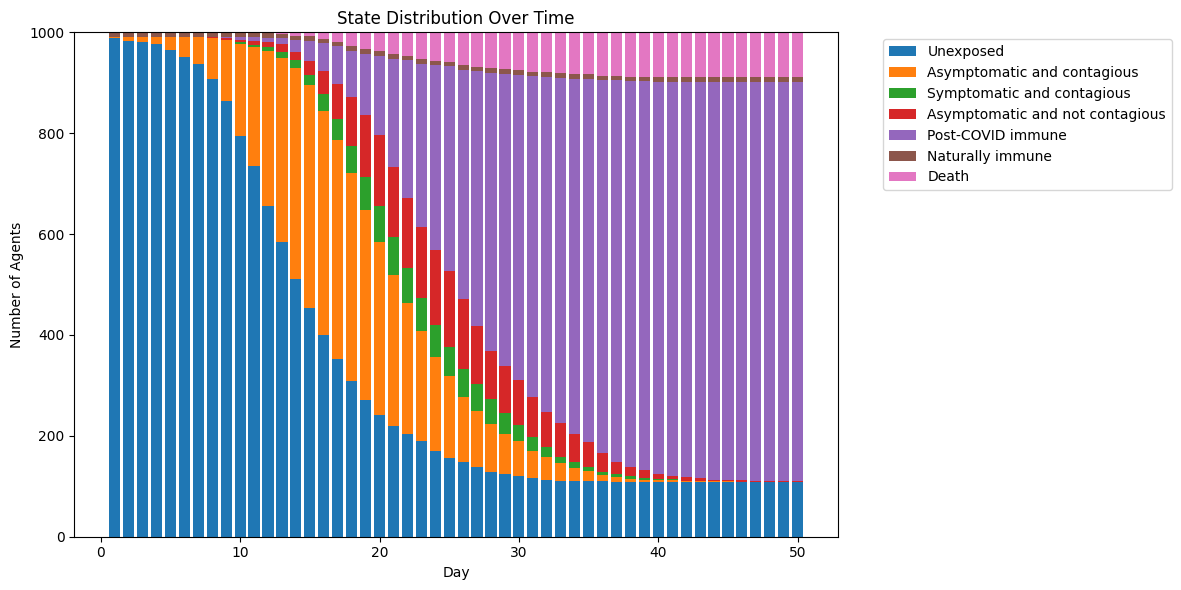

In [32]:
agents = initialize_agents(numAgents)
agents = infect_initial_agents(agents)

disthistory_df = simulate_spread_with_network(social_network, agents, num_interactions=10, num_days=50, contagion_prob=0.1)

plt.figure(figsize=(12, 6))
bottom_values = np.zeros(len(disthistory_df))
for state in STATENAMES:
    plt.bar(disthistory_df['day'], disthistory_df[state], label=state, bottom=bottom_values)
    bottom_values += disthistory_df[state]

plt.xlabel('Day')
plt.ylabel('Number of Agents')
plt.title('State Distribution Over Time')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

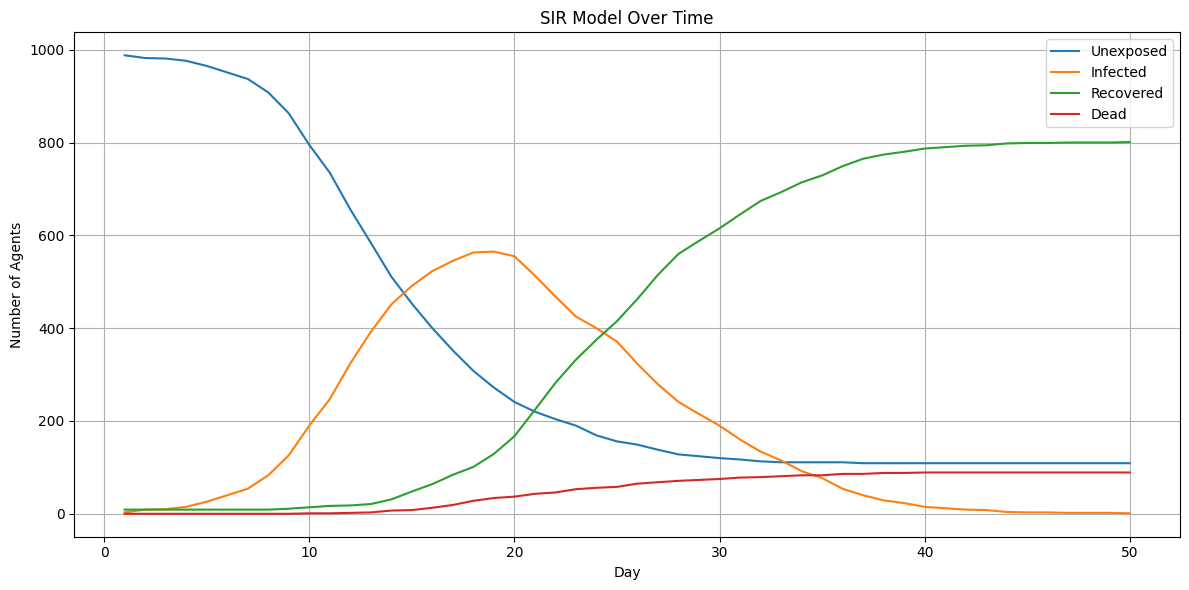

In [33]:

sir = pd.DataFrame({
    'day': disthistory_df['day'],
    'Unexposed': disthistory_df['Unexposed'],
    'infected': disthistory_df['Asymptomatic and contagious'] + disthistory_df['Symptomatic and contagious']+ disthistory_df['Asymptomatic and not contagious'],
    'recovered':  disthistory_df['Post-COVID immune'] + disthistory_df['Naturally immune'],
    'Dead': disthistory_df['Death']
})

sir_long = pd.melt(sir, id_vars=['day'], var_name='State', value_name='Count')

plt.figure(figsize=(12, 6))
for state in ['Unexposed', 'infected', 'recovered', 'Dead']:
    subset = sir_long[sir_long['State'] == state]
    plt.plot(subset['day'], subset['Count'], label=state.capitalize())

plt.xlabel('Day')
plt.ylabel('Number of Agents')
plt.title('SIR Model Over Time')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

The addition of super-spreaders accelerated the spread of the epidemic, resulting in a rapid peak in the number of infected people in a short period of time, and a rapid rise in the number of recovered people.

Under the influence of the variant strain, the peak of infection lasted longer, and the ratio between the number of recoveries and the number of deaths changed more dramatically. During the peak period, the number of infections declined more slowly, indicating that the mutant strain has a strong ability to spread, resulting in a longer duration of infection.

Variant strains bring higher mortality rates, resulting in a faster rise in the number of deaths and a slower rise in the number of people recovering from peak infections; While super-spreaders have accelerated the spread of the epidemic, the death toll has risen more slowly.

## Part 4 The impact of policy changes on the COVID-19 pandemic

The main goal of this simulation is to explore how changing daily interaction rates, simulating quarantine policies, affects the spread of the virus. We simulate a quarantine period from day 10 to day 25 where interactions are reduced, and then interactions return to normal levels after this period.

The simulation introduces a new list-based approach for , which allows us to modify the number of interactions for specific days, reflecting policy changes over time.num_interactions


Pre-quarantine period (Days 1–9): Agents interact normally with 10 daily interactions.

Quarantine period (Days 10–25): The interaction rate drops significantly to just 3 daily interactions, simulating lockdown or social distancing.

Post-quarantine period (Days 26–70): Interactions return to normal levels after quarantine is lifted.

In [34]:
# Define interactions, contagion probabilities, and network sampling rates during policy changes
num_days = 70  # Simulation is for 70 days

# Ensure the length of each array matches num_days
num_interactions = [10] * 9 + [3] * 16 + [10] * (num_days - 25)  # Quarantine from day 10 to day 25
contagion_prob = [0.1] * num_days  # Constant contagion probability
sample_from_network = [0.95] * num_days  # Constant network interaction probability

In [35]:
def simulate_spread_with_policy(social_network, agents, num_interactions, contagion_prob, sample_from_network, num_days=50):
    disthistory = []

    for day in range(1, num_days + 1):
        sneezeOn = []
        # Generate interactions for each agent

        for agent_id in range(len(agents)):
            agent = agents[agent_id]

            adjusted_interactions = num_interactions[day - 1]  # Depending on the number of interactions per day

            if agent['super_spreader']:
                adjusted_interactions *= 3
            elif agent['biostate'] in [2, 3]:  # A common agent with symptoms
                adjusted_interactions = max(1, adjusted_interactions // 2)  # Reduce the number of interactions

            # Generative interaction
            for _ in range(adjusted_interactions):
                if random.random() < sample_from_network[day - 1]:
                    # Choose who to interact with from your social network
                    neighbors = list(social_network.neighbors(agent_id))
                    partner_id = random.choice(neighbors) if neighbors else random.randrange(len(agents))
                else:
                    partner_id = random.randrange(len(agents))
                sneezeOn.append((agent_id, partner_id))

        # Simulated virus transmission
        for agent1_id, agent2_id in sneezeOn:
            agent1 = agents[agent1_id]
            agent2 = agents[agent2_id]

            # Calculated infection probability
            adjusted_contagion_prob = contagion_prob[day - 1]
            if agent1['super_spreader']:
                adjusted_contagion_prob *= 2  # Super spreaders have a higher probability of infection

            # If agent1 is the infectious agent and agent2 is not exposed, the infection is determined
            if (agent1['biostate'] in [2, 3]) and (agent2['biostate'] == 1):
                if random.random() < adjusted_contagion_prob:
                    agents[agent2_id] = setAgentState(agents[agent2_id], 2)

        for i in range(len(agents)):
            agents[i] = updateAgent(agents[i])
        biostates = [agent['biostate'] for agent in agents]
        distrib = Counter(biostates)
        day_distrib = [distrib.get(state, 0) for state in range(1, 8)]
        disthistory.append(day_distrib)
    disthistory_df = pd.DataFrame(disthistory, columns=STATENAMES)
    disthistory_df['day'] = range(1, num_days + 1)

    return disthistory_df

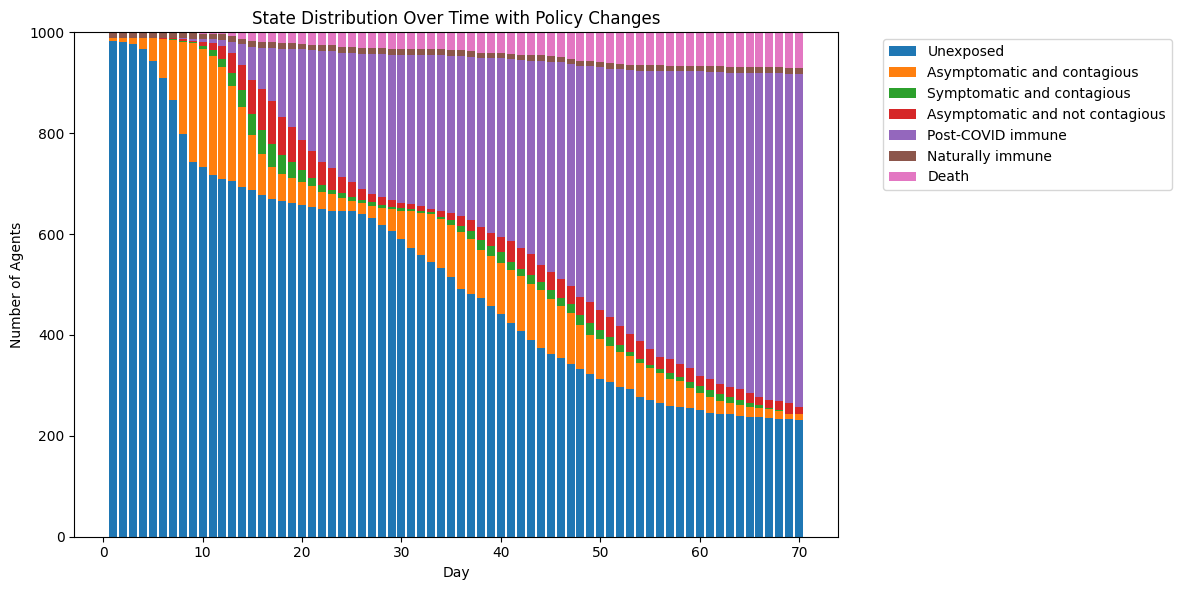

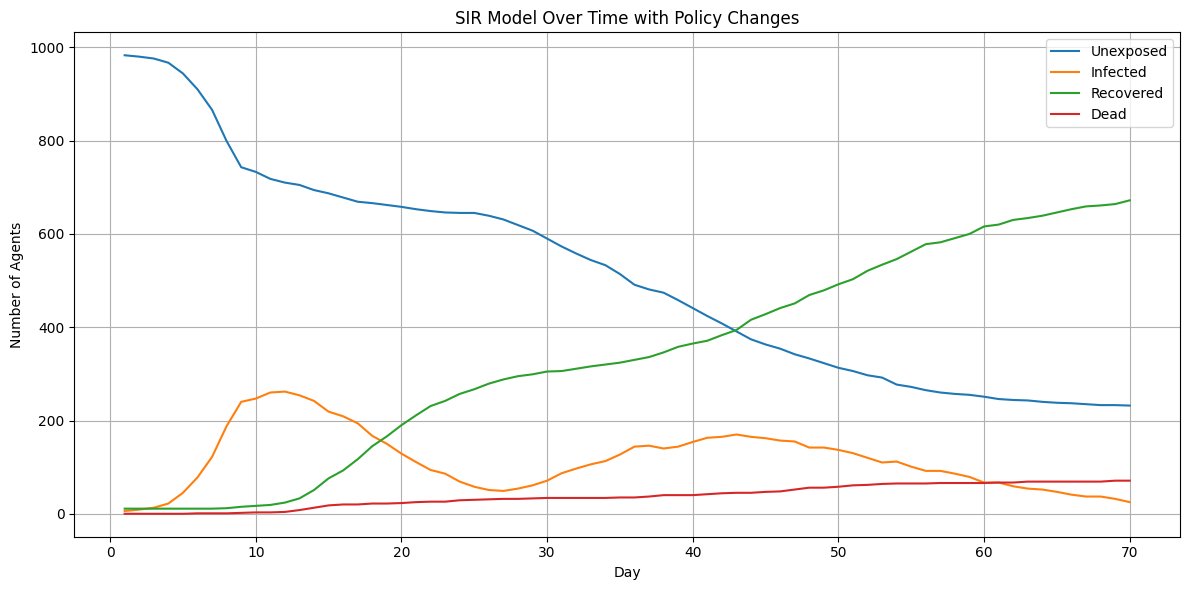

In [36]:
agents = initialize_agents(numAgents)
agents = infect_initial_agents(agents)
disthistory_df = simulate_spread_with_policy(social_network, agents, num_interactions, contagion_prob, sample_from_network, num_days)

# 可视化结果
plt.figure(figsize=(12, 6))
bottom_values = np.zeros(len(disthistory_df))
for state in STATENAMES:
    plt.bar(disthistory_df['day'], disthistory_df[state], label=state, bottom=bottom_values)
    bottom_values += disthistory_df[state]

plt.xlabel('Day')
plt.ylabel('Number of Agents')
plt.title('State Distribution Over Time with Policy Changes')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


sir = pd.DataFrame({
    'day': disthistory_df['day'],
    'Unexposed': disthistory_df['Unexposed'],
    'infected': disthistory_df['Asymptomatic and contagious'] + disthistory_df['Symptomatic and contagious']+ disthistory_df['Asymptomatic and not contagious'],
    'recovered':  disthistory_df['Post-COVID immune'] + disthistory_df['Naturally immune'],
    'Dead': disthistory_df['Death']
})

sir_long = pd.melt(sir, id_vars=['day'], var_name='State', value_name='Count')

plt.figure(figsize=(12, 6))
for state in ['Unexposed', 'infected', 'recovered', 'Dead']:
    subset = sir_long[sir_long['State'] == state]
    plt.plot(subset['day'], subset['Count'], label=state.capitalize())

plt.xlabel('Day')
plt.ylabel('Number of Agents')
plt.title('SIR Model Over Time with Policy Changes')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [37]:
show = disthistory_df.iloc[::5, :]
print(show.to_string(index=False))

 Unexposed  Asymptomatic and contagious  Symptomatic and contagious  Asymptomatic and not contagious  Post-COVID immune  Naturally immune  Death  day
       983                            6                           0                                0                  0                11      0    1
       910                           77                           0                                1                  0                11      1    6
       718                          235                          11                               14                  8                11      3   11
       678                           81                          47                               81                 82                11     20   16
       653                           42                          17                               52                200                11     25   21
       639                           23                           6                               22

In the early stages (before quarantine, days 1-9), the number of infected people gradually increases. This follows a typical infection curve where more people are exposed to the virus due to social interactions and super-spreader dynamics.

Between day 10 and day 25 (during the quarantine period), the rate of infection decreased significantly. The number of daily interactions decreased, reducing the spread of the virus. However, the overall decline in the number of infections was slower than expected, and the number of infections never fell to zero.

After the 25th day, when interactions return to normal, the number of infections increases substantially. This is evident in the rapid growth of asymptomatic and symptomatic infections. While isolation suppresses the virus during execution, it also prolongs the presence of uncontacted individuals who are susceptible to infection in the future. Once social restrictions are lifted, this can lead to a comeback.

The quarantine period moves the pandemic curve forward, but does not eliminate the virus. Recovery rates continued to rise slowly, but the overall outbreak was prolonged by policy interventions. The SIR Model diagram shows that the infection curve has become wider and more elongated, thereby extending the pandemic timeline. In contrast, without such a policy (as observed in the previous section), infection peaks occur earlier and are resolved more quickly.

## Conclusion

This COVID-19 simulation model brings together multiple factors—individual health states, social behaviors, super-spreaders, virus variants, and policy interventions like quarantine—to accurately reflect the complexities of a pandemic. By simulating interactions within structured social networks and incorporating random health state transitions, the model mimics real-world virus transmission patterns, illustrating how changes in behavior can influence outcomes. The role of super-spreaders and virus variants is particularly notable, as both have a significant impact on the intensity of an outbreak. Meanwhile, policy measures, such as quarantine, reveal the delicate balance between slowing the spread of the virus and potentially prolonging the pandemic's duration. 

## Reference

Ritchie, H., & Roser, M. (2024, February). Age structure. Our World in Data. https://ourworldindata.org/age-structure



Centers for Disease Control and Prevention. (n.d.). Risk for COVID-19 infection, hospitalization, and death by age group. U.S. Department of Health and Human Services. https://www.cdc.gov/coronavirus/2019-ncov/covid-data/investigations-discovery/hospitalization-death-by-age.html


Byrne, A. W., McEvoy, D., Collins, Á. B., Hunt, K., Casey, M., Barber, A., Butler, F., Griffin, J., Lane, E. A., McAloon, C., O'Brien, K., Wall, P., Walsh, K. A., & More, S. J. (2020). Inferred duration of infectious period of SARS-CoV-2: Rapid scoping review and analysis of available evidence for asymptomatic and symptomatic COVID-19 cases. BMJ Open, 10(8), e039856. https://doi.org/10.1136/bmjopen-2020-039856



